In [1]:
import sys
import os

import neo.io

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline

import tqdm

from collections import Counter

import pandas as pd

from statistics import calc_cv, calc_burst_by_mean, calc_local_variance

from sklearn.metrics import silhouette_score

In [2]:
def plot_spikes(spikes, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(15,10))

    for i in range(len(spikes)):
        ax.plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.2)
    
    ax.set_ylim([-5., 5.])

In [55]:
def read_spikes(dist_dir):
    all_data = list()

    for root, subdirs, files in os.walk(dist_dir):
        for full_name, f_name in [(os.path.join(root, f_name), f_name) for f_name in files]:
            patient = full_name.split(os.sep)[3]
            ext = full_name[-3:].lower()

            if ext == 'nex':
                r = neo.io.NeuroExplorerIO(filename=full_name)
                for blk in r.read(cascade=True, lazy=False):
                    for seg in blk.segments:
                        for st in seg.spiketrains:
                            name_lower = str(st.name.lower())
                            if name_lower.startswith('fon'):
                                spikes = np.array(st)
                                for interval in seg.epochs:
                                    int_name = interval.annotations['channel_name'].lower()
                                    if name_lower.startswith(int_name):
                                        for s, d in zip(interval.times, interval.durations):
                                            e = s + d
                                            spikes_filtered = spikes[np.where((spikes >= s) & (spikes <= e))]
                                            if len(spikes_filtered) > 100 and (spikes_filtered[~0] - spikes_filtered[0]) > 5.:
                                                isi = spikes_filtered[1:] - spikes_filtered[:-1]
                                                
                                                df = dict()                                              
                                                df['st'] = spikes_filtered
                                                df['cv'] = calc_cv(isi)
                                                df['AI'] = calc_burst_by_mean(isi)
                                                df['patient'] = patient
                                                df['data_name'] = st.name
                                                df['doc_name'] = f_name
                                                df['interval_name'] = int_name
                                                df['lv'] = calc_local_variance(isi)

                                                all_data.append(df)

                            elif name_lower.startswith('allfile') or name_lower.startswith('nw'):
                                spikes = np.array(st)
                                if len(spikes) > 50 and (spikes[~0] - spikes[0] > 5.):  
                                    isi = spikes[1:] - spikes[:-1]
                                    
                                    df = dict()
                                    df['st'] = spikes
                                    df['cv'] = calc_cv(isi)
                                    df['AI'] = calc_burst_by_mean(isi)
                                    df['patient'] = patient
                                    df['data_name'] = st.name
                                    df['doc_name'] = f_name
                                    df['interval_name'] = 'allfile'
                                    df['lv'] = calc_local_variance(isi)

                                    all_data.append(df)
                                    
    return all_data


In [56]:
# stat_data = pd.read_excel('awake.xls')

In [57]:
# fig = plt.figure(figsize=(15,10))
# sc = plt.scatter(stat_data['cv'], stat_data['burst_mean'], c=stat_data['burst_spike_percent'])

# cbar = fig.colorbar(sc, ticks=[-1, 0, 1])

# plt.xlabel('cv')
# plt.ylabel('AI')

In [58]:
dist_dir_a = 'C:\\projects\\neuro_data\\data_for_analyze\\awake'
dist_dir_s = 'C:\\projects\\neuro_data\\data_for_analyze\\sleep'

In [59]:
data_a = read_spikes(dist_dir_a)
data_s = read_spikes(dist_dir_s)

In [191]:
only_st = list()
names = list()
labels = list()
cv_ai = list()

for d in data_a:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['doc_name'], d['data_name'], d['interval_name']))
    
        labels.append(1)
        cv_ai.append((d['cv'], d['AI'], d['lv']))
#     if len(only_st) == 50:
#         break
        
    
for d in data_s:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['doc_name'], d['data_name'], d['interval_name']))
    
        labels.append(0)
        cv_ai.append((d['cv'], d['AI'], d['lv']))
#     if len(only_st) == 100:
#         break

In [192]:
cv_ai = np.array(cv_ai)

In [61]:
# cv_ai = [stat_dict[n] for n in names]
only_isi = [st[1:] - st[:-1] for st in only_st]
logisi = [np.log(isi[np.nonzero(isi)]) for isi in only_isi]

In [62]:
len(only_st), len(names)

(627, 627)

In [63]:
def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res

In [259]:
def boot_fit(x, dist, iters=100):
    params = np.array([dist.fit(np.random.choice(x, size=len(x))) for _ in range(iters)])
    return np.mean(params, axis=0)

# def JSD(P, Q):
#     _P = P / np.linalg.norm(P, ord=1)
#     _Q = Q / np.linalg.norm(Q, ord=1)
#     _M = 0.5 * (_P + _Q)
#     return 0.5 * (sp.stats.entropy(_P, _M) + sp.stats.entropy(_Q, _M))

def JSD(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    p = np.asarray(p)
    q = np.asarray(q)
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

def logisi_gamma_metric(x, y):
    x_norm = x/np.max(x)
    y_norm = y/np.max(y)
    
    a1,b1,s1 = sp.stats.gamma.fit(x)
    a2,b2,s2 = sp.stats.gamma.fit(y)
    
    x_axis = np.arange(-10, 10, 0.001)
    d1 = sp.stats.gamma.pdf(x_axis, a1, b1, s1)
    d2 = sp.stats.gamma.pdf(x_axis, a2, b2, s2)
    
    return JSD(d1, d2)


def get_sdh(st, norm = True):
    isi = st[1:] - st[:-1]
    splitted = clever_split(st, np.mean(isi))
    counts = Counter([len(t) for t in splitted])
        
    res = np.zeros(max(counts.keys()) + 1)
    
    for idx, val in counts.items():
        res[idx] = val
    
    if(norm):
        res /= sum(res)
    
    return res    


def pad_to_size(arr, sz, val):
    res = np.full(sz, val, dtype=float)
    res[:len(arr)] = arr
    
    return res


def get_sdh_window(st, windows=5):
    splits = np.array_split(st, windows)
    sdh_lst = [get_sdh(spl) for spl in splits]
    max_len = max([len(sdh) for sdh in sdh_lst])
    
    sdh_lst = [pad_to_size(sdh, max_len, 0.) for sdh in sdh_lst]
    
    sdh_total = np.sum(sdh_lst, axis=0)
    
    sdh_total /= sum(sdh_total)
    return sdh_total


def sdh_poisson_metric(x, y, windows=10):
    sdh1 = get_sdh_window(x, windows)
    sdh2 = get_sdh_window(y, windows)
        
    max_len = max(len(sdh1), len(sdh2))

    sdh1 = pad_to_size(sdh1, max_len, 0)
    sdh2 = pad_to_size(sdh2, max_len, 0)

    return JSD(sdh1, sdh2)


def build_matrix_precalc(arr, metric, cashed):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res 


def build_matrix(arr, metric):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res

In [240]:
def sdh_poisson_metric_precalc(sdh1, sdh2):
    max_len = max(len(sdh1), len(sdh2))

    sdh1_p = pad_to_size(sdh1, max_len, 0)
    sdh2_p = pad_to_size(sdh2, max_len, 0)

    return JSD(sdh1_p, sdh2_p)


def build_matrix_precalc(arr, metric, cashed):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(cashed[i], cashed[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res 


In [241]:
# labels = np.zeros(100)
# labels[:50] = 1

In [242]:
# M_isi = build_matrix(logisi, logisi_gamma_metric)

In [243]:
# Z_isi = linkage(M_isi[np.triu_indices(M_isi.shape[0], 1)], 'ward')

# plt.figure(figsize=(15,10))
# d_dct = dendrogram(Z_isi)

# ax = plt.gca()

# for lbl in ax.get_xmajorticklabels():
#     idx = int(lbl.get_text())
#     if labels[idx]:
#         lbl.set_color('red')
#     else:
#         lbl.set_color('green')

In [244]:
# fcluster(Z_isi, 0.5, criterion="distance")

In [245]:
# cut_isi = fcluster(Z_isi, 0.5, criterion="distance")
# plt.figure(figsize=(15,10))
# plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], c=cut_isi)

In [246]:
# idx = [i for i, c in enumerate(cv_ai) if c[0] > 10]
# print(idx)

In [247]:
sdh_vals = [get_sdh(st) for st in tqdm.tqdm_notebook(only_st)]
M = build_matrix_precalc(only_st, lambda x, y: sdh_poisson_metric_precalc(x, y), sdh_vals)

A Jupyter Widget

A Jupyter Widget

In [248]:
# M = build_matrix(only_st, lambda x, y: sdh_poisson_metric(x, y, 3))

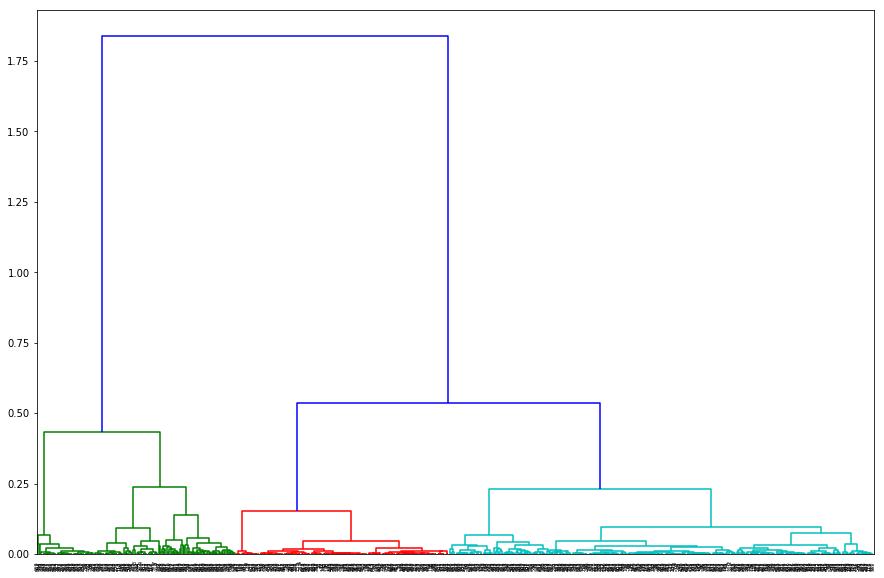

In [277]:
Z = linkage(M[np.triu_indices(M.shape[0], 1)], 'ward')

plt.figure(figsize=(15,10))
d_dct = dendrogram(Z, color_threshold=0.5)

ax = plt.gca()



# for lbl in ax.get_xmajorticklabels():
#     idx = int(lbl.get_text())
#     if idx == 3:
#         lbl.set_color('red')
        
#     if labels[idx]:
#         lbl.set_color('red')
#     else:
#         lbl.set_color('green')

# for lbl in ax.get_xmajorticklabels():
#     idx = int(lbl.get_text())
#     if labels[idx]:
#         lbl.set_color('red')
#     else:
#         lbl.set_color('green')

In [287]:
cut = fcluster(Z, 0.5, criterion="distance")
print(np.unique(cut))

[1 2 3]


In [288]:
# plt.figure(figsize=(15,10))
# for l, col, name in zip(np.unique(cut), ['r','g','b'], ['burst', 'tonic', 'irregular']):
#     idx = np.where(cut == l)
#     plt.scatter(cv_ai[idx, 0], cv_ai[idx, 1], color=col, s=5, label=name)
# # plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], cmap='plasma', c=cut, s=5)

# plt.xlim([0, 10])

# plt.xlabel('CV')
# plt.ylabel('AI')
# plt.legend()

In [289]:
sdh_dct = dict()
for l in np.unique(cut):
    idx = np.where(cut == l)
    sdh_dct[l] = all_sdh[idx]

In [290]:
cvai_stats = dict()
for l in np.unique(cut):
    idx = np.where(cut == l)
    print(l)
    print(np.median(cv_ai[idx], axis=0))
    print(np.min(cv_ai[idx], axis=0))
    print(np.max(cv_ai[idx], axis=0))

1
[ 1.56541346  0.44553771  0.75960764]
[ 0.6269268   0.05176429  0.28727132]
[ 20.59936103   0.82802973   1.21378524]
2
[ 0.97979372  0.70301312  0.65393279]
[ 0.46523984  0.57930223  0.18660103]
[ 2.40185434  0.96807713  0.90705557]
3
[ 1.41965475  0.51551957  0.76740415]
[ 0.79052567  0.20523416  0.21170958]
[ 6.77908283  0.79591023  1.33706119]


In [291]:
sdh_padded = dict()
for k, val in sdh_dct.items():
    max_len = np.max([len(s) for s in val])
    print(np.max([len(s) for s in val]), np.median([len(s) for s in val]))
    
    padded = np.array([pad_to_size(sdh, max_len, 0.) for sdh in val])
    sdh_padded[k] = padded

38 8.0
8 5.0
18 7.0


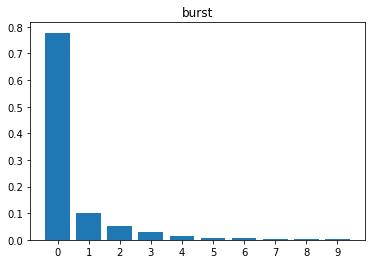

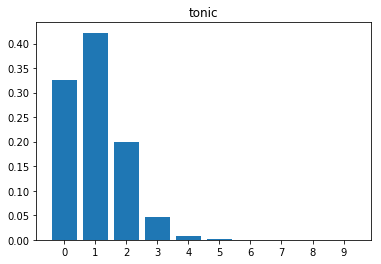

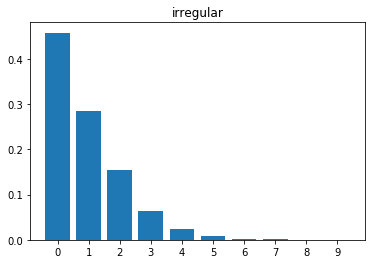

In [292]:
mean_dct = dict()
for name, (k, val) in zip(['burst', 'tonic', 'irregular'], sdh_padded.items()):
    mean_sdh = np.mean(val, axis=0)
    
    if len(mean_sdh) < 10:
        mean_sdh = pad_to_size(mean_sdh, 10, 0.)
    else:
        mean_sdh = mean_sdh[:10]
        
    mean_dct[k] = mean_sdh
    
    plt.figure()
    plt.bar(np.arange(10), mean_sdh)
    plt.title(name)
    
    plt.xticks(np.arange(10))

In [297]:
def get_nearest_cluster(sdh):   
    if len(sdh) < 10:
        sdh = pad_to_size(sdh, 10, 0.)
    else:
        sdh = sdh[:10]
    
    res, min_dist = -1, 100500
    for k, val in mean_dct.items():
        curr_dist = JSD(sdh, val)
        if curr_dist < min_dist:
            res, min_dist = k, curr_dist
    
    return res
    

In [302]:
labels = np.array([get_nearest_cluster(sdh) for sdh in sdh_vals])

In [307]:
np.where(cv_ai[:,0] == np.min(cv_ai[labels == 1, 0]))

(array([235], dtype=int64),)

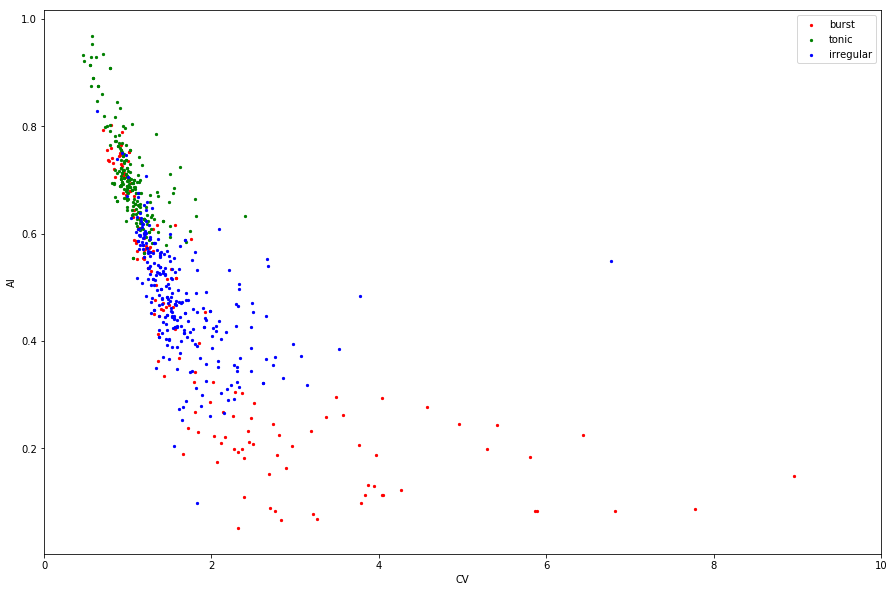

In [301]:
plt.figure(figsize=(15,10))
for l, col, name in zip(np.unique(labels), ['r','g','b'], ['burst', 'tonic', 'irregular']):
    idx = np.where(labels == l)
    plt.scatter(cv_ai[idx, 0], cv_ai[idx, 1], color=col, s=5, label=name)
# plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], cmap='plasma', c=cut, s=5)

plt.xlim([0, 10])

plt.xlabel('CV')
plt.ylabel('AI')
plt.legend()

In [ ]:
np.where(cv_ai[:, 0] == 0.62692679606703849)
plt.bar(np.arange(sdh_vals[3].shape[0]), sdh_vals[3])
plot_spikes(only_st[3])

In [257]:
strange_sdh = pad_to_size(sdh_vals[3], 10, 0.)

In [261]:
for k, val in mean_dct.items():
    dist = JSD(strange_sdh, val)
    print(k, ':', dist)

1 : 0.0403464764415
2 : 0.0591536918675
3 : 0.0397606698151


In [169]:
tonic_inc = [0.1]
isi = 0.3
for _ in range(500):
    tonic_inc.append(tonic_inc[~0] + isi)
    isi *= 0.995

tonic_inc = np.array(tonic_inc)
isi_inc = tonic_inc[1:] - tonic_inc[:-1]

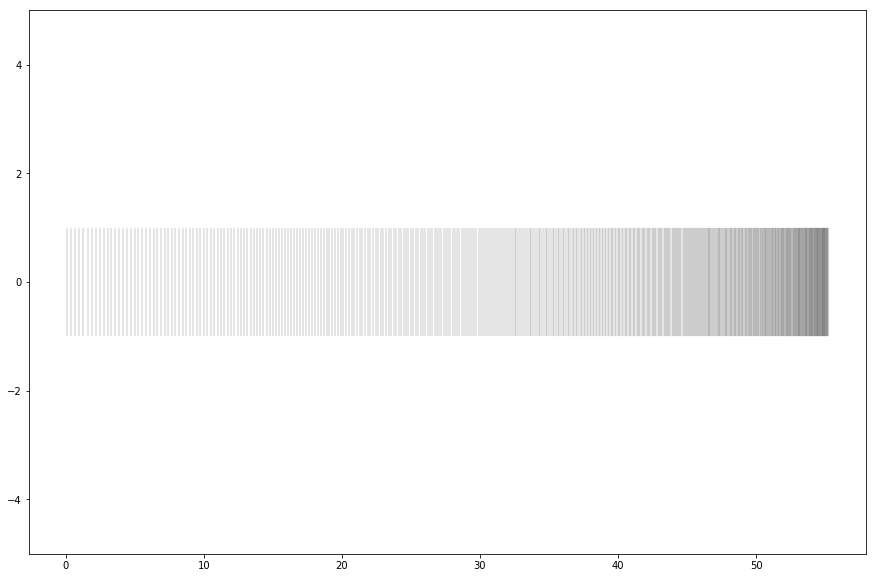

In [170]:
plot_spikes(tonic_inc)

(-5.0, 5.0)

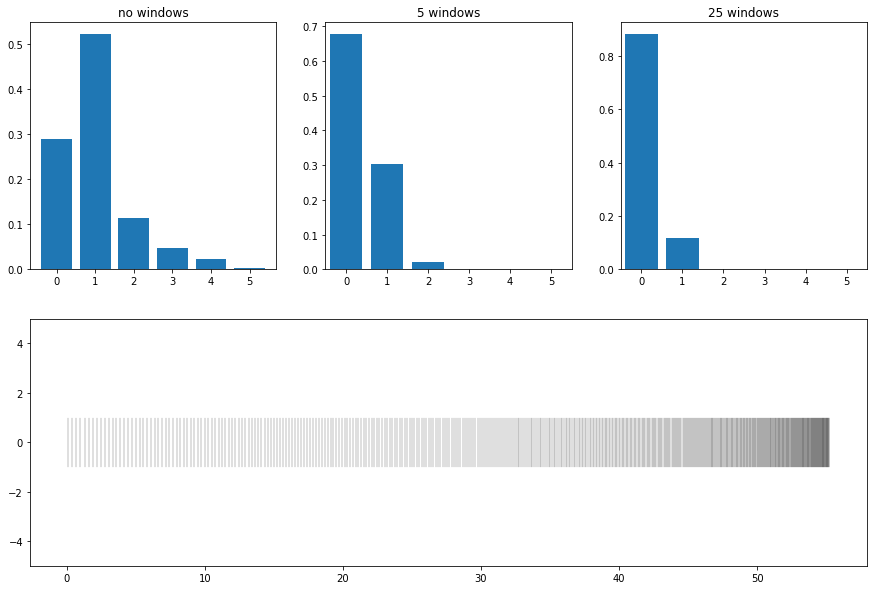

In [172]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,10))

fig = plt.figure(1, figsize=(15,10))
gridspec.GridSpec(2,3)

sdh = get_sdh(tonic_inc)
plt.subplot2grid((2,3), (0,0))
plt.bar(np.arange(sdh.shape[0]), sdh)
plt.title('no windows')

sdh_w = get_sdh_window(tonic_inc, windows=5)
plt.subplot2grid((2,3), (0,1))
plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
plt.title('5 windows')
plt.xlim([-0.5, 5.5])

sdh_w = get_sdh_window(tonic_inc, windows=25)
plt.subplot2grid((2,3), (0,2))
plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
plt.title('25 windows')
plt.xlim([-0.5, 5.5])

plt.subplot2grid((2,3), (1,0), colspan=3, rowspan=1)
for i in range(len(tonic_inc)):
    plt.plot([tonic_inc[i], tonic_inc[i]], [-1, 1], color='black', lw=0.25)

plt.ylim([-5., 5.])
# # plot_spikes(tonic_inc, ax=ax3)

# # fig.tight_layout()

In [171]:
# plt.figure(figsize=(15,10))
# plt.scatter(isi_inc[:-1], isi_inc[1:], s=5)

In [173]:
st_tonic_sn = [0.1]
isi = 0.05
for i in range(500):
    j = i*np.pi/16
    st_tonic_sn.append(st_tonic_sn[~0] + isi*(np.sin(j) + 1))
    
st_tonic_sn = np.array(st_tonic_sn)
isi_sn = st_tonic_sn[1:]- st_tonic_sn[:-1]

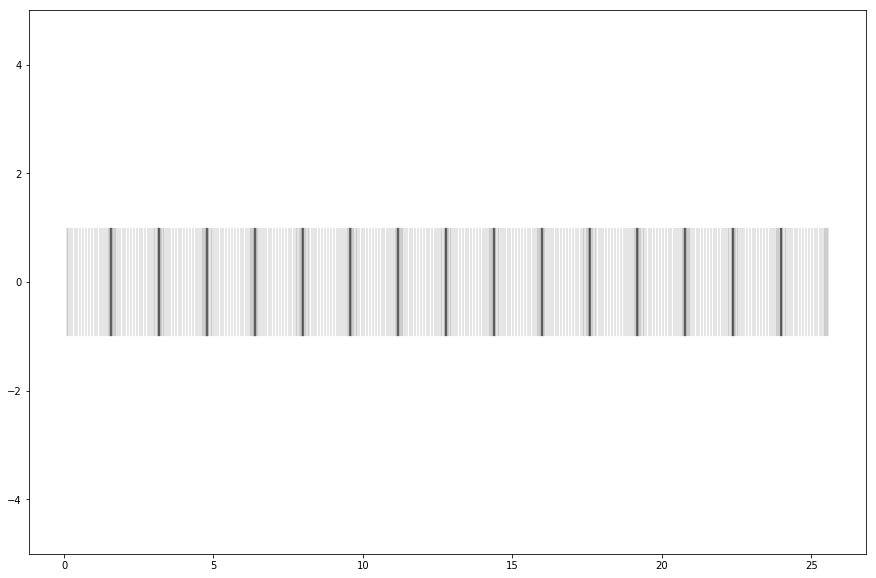

In [174]:
plot_spikes(st_tonic_sn)

<Container object of 10 artists>

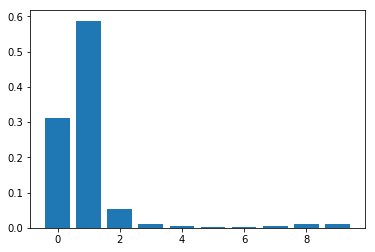

In [177]:
sdh_bursty = get_sdh_window(st_tonic_sn, 1)
plt.bar(np.arange(sdh_bursty.shape[0]), sdh_bursty)

(-5, 5)

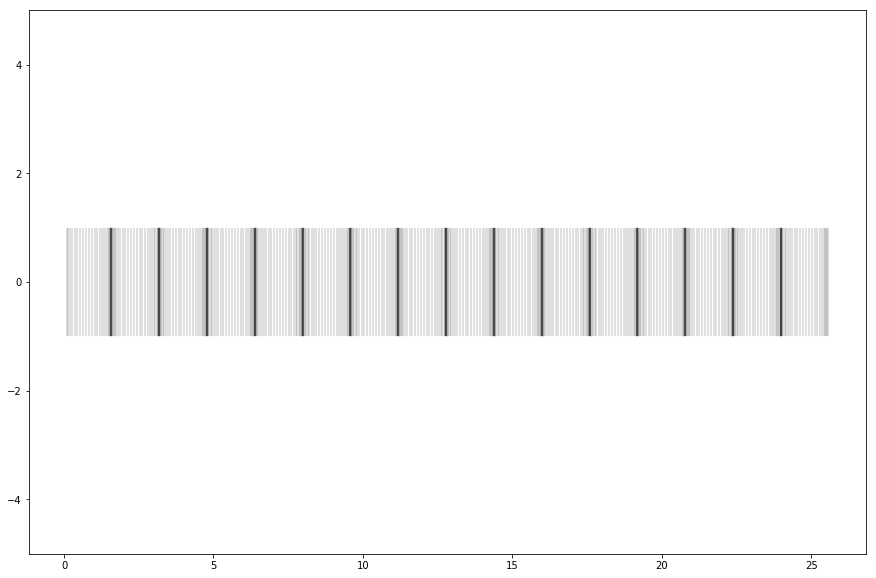

In [288]:
# plt.figure(figsize=(15, 10))
# for i in range(len(tonic_inc)):
    
#     plt.plot([st_tonic_sn[i], st_tonic_sn[i]], [-1, 1], color='black', lw=0.25)

# plt.ylim([-5, 5])

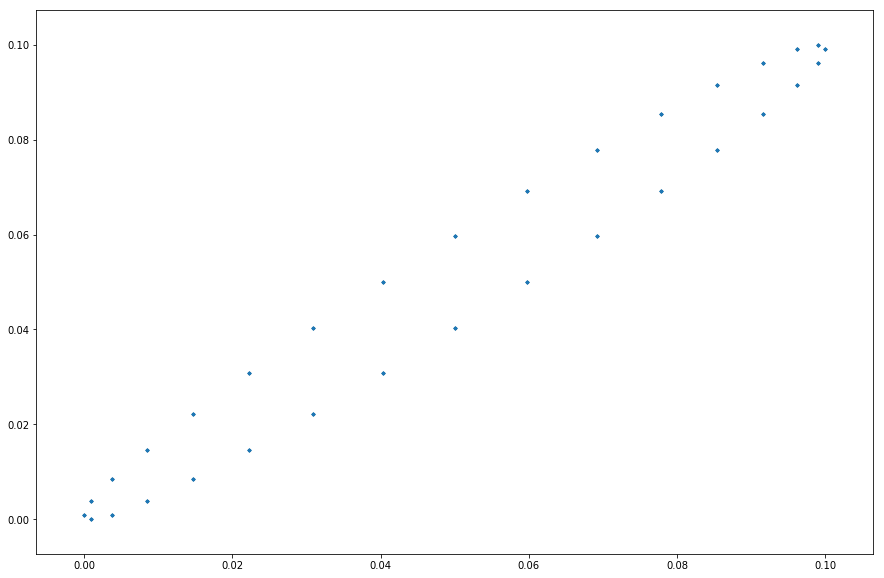

In [290]:
plt.figure(figsize=(15,10))
plt.scatter(isi_sn[:-1], isi_sn[1:], s=5)